# Assignment 4 - dimensionality reduction

This assignment focuses on two different ways for dimensionality reduction:
* feature selection
* feature extraction

This assignment has weighting $1.5$.

# Sequential feature selection (50 points)

There is a sample code in PML chapter 4 for sequential bardward selection (SBS) and its application to subsequent KNN classifier.

Implement sequential forward selection (SFS), and compare it with sequential backward selection by plotting the accuracy versus the number of features.

You can start with the sample code provided in the [slides](http://nbviewer.jupyter.org/github/1iyiwei/pyml/blob/master/code/ch04/ch04.ipynb).
You can extend the existing SBS class to handle both forward and backward selection, or implement a separate class for SFS.
Plot and compare the two accuracy versus number-of-features plots for SFS and SBS.

Use the wine dataset as follows.

In [113]:
import pandas as pd

wine_data_remote = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
wine_data_local = '../datasets/wine/wine.data'

df_wine = pd.read_csv(wine_data_remote,
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

#print('Class labels', np.unique(df_wine['Class label']))
#df_wine.head()

In [114]:
from sklearn import __version__ as skv
from distutils.version import LooseVersion as CheckVersion
if CheckVersion(skv) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)

In [115]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

## Answer

Implement your sequential backward selection class here, either as a separate class or by extending the SBS class that can handle both forward and backward selection (via an input parameter to indicate the direction).

In [116]:
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from itertools import combinations
import numpy as np

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [117]:
class SFS():
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = []
        self.scores_ = []
        indices_ = []

        if dim >= self.k_features:
            while len(self.subsets_) < self.k_features:
                scores = []
                subsets = []
                
                for p in combinations(tuple(list(set(self.indices_)-set(indices_))), 1):
                    score = self._calc_score(X_train, y_train, X_test, y_test, p+tuple(indices_))
                    scores.append(score)
                    subsets.append(p+tuple(indices_))
                best = np.argmax(scores)
                indices_ = subsets[best]
                self.subsets_.append(indices_)               
                self.scores_.append(scores[best])

        self.k_score_ = self.scores_[-1]
                
        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

Apply your sequential forward/backward selection code to the KNN classifier with the wine data set, and plot the accuracy versus number-of-features curves for both.
Describe the similarities and differences you can find, e.g. 
* do the two methods agree on the optimal number of features?
* do the two methods have similar accuracy scores for each number of features?
* etc.

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')
Index(['Total phenols', 'Alcohol', 'Color intensity'], dtype='object')


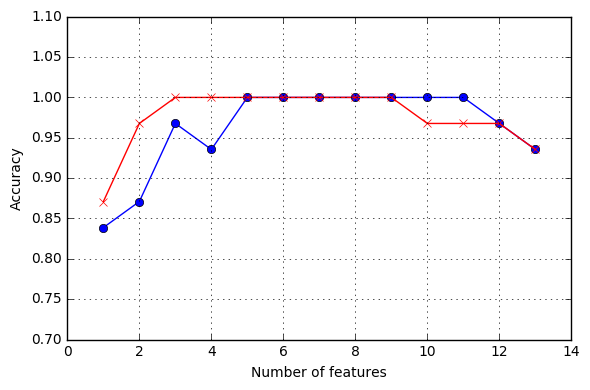

In [118]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

# selecting features
sbs = SBS(knn, k_features=1)
sfs = SFS(knn, k_features=13)
sbs.fit(X_train_std, y_train)
sfs.fit(X_train_std, y_train)

# list several most important features
k5_sbs = list(sbs.subsets_[8]) # 5+8 = 13
k3_sfs = list(sfs.subsets_[2])
print(df_wine.columns[1:][k5_sbs])
print(df_wine.columns[1:][k3_sfs])

# plotting performance of feature subsets
k_feat_sbs = [len(k) for k in sbs.subsets_]
k_feat_sfs = [len(k) for k in sfs.subsets_]
plt.plot(k_feat_sbs, sbs.scores_, marker='o')

plt.plot(k_feat_sfs, sfs.scores_, marker='x', color='red')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()

plt.show()

SBS and SFS don't agree on the optimal number of features, with 5 and 3 respectively. And the optimal features are almost different.
These two methods share similar accuracy scores for each number of features, which could be inferred from the table. And the trends of accuracy scores regarding the number of features are very similar. For both methods, the optimal accuray scores are very close to 1.

# PCA versus LDA (50 points)

We have learned two different methods for feature extraction, PCA (unsupervised) and LDA (supervised).

Under what circumstances would PCA and LDA produce very different results? 

Provide one example dataset in 2D, analyze it via PCA and LDA, and plot it with the PCA and LDA components.

You can use code from the scikit-learn library.

## Answer

In [119]:
%matplotlib inline

Write code to produce your own dataset in 2D.
You are free to design relative characteristics like the number of class, the number of samples for each class, as long as your dataset could be analyzed via PCA and LDA.

In [120]:
import random
rank = [3 for i in range(33)] + [2 for i in range(33)] + [1 for i in range(34)]
appearance = [round(random.uniform(0,10),2) for i in range(1,101)]
taste = [round(random.uniform(0,3),2) for i in range(33)] + [round(random.uniform(3,6),2) for i in range(33)] + [round(random.uniform(6,10),2) for i in range(34)]
d = {'Rank' : rank,
     'taste' : taste,
     'appearance' : appearance}
df_dessert = pd.DataFrame(d)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X, y = df_dessert.iloc[:, 1:].values, df_dessert.iloc[:, 0].values
X_std = sc.fit_transform(X)

Plot your data set, with different classes in different marker colors and/or shapes.

You can write your own plot code or use existing library plot code.

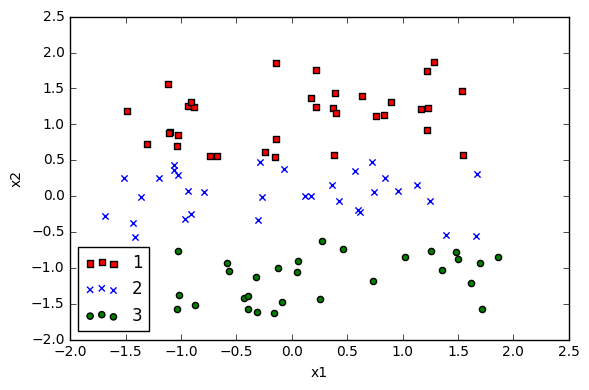

In [121]:
X_plot = X_std

colors = ['r', 'b','g']
markers = ['s', 'x','o']

for l, c, m in zip(np.unique(y), colors, markers):
    plt.scatter(X_plot[y == l, 0], X_plot[y == l, 1], c=c, label=l, marker=m)
    
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

Apply your dataset through PCA and LDA, and plot the projected data using the same plot code.
Explain the differences you notice, and how you manage to construct your dataset to achieve such differences.

You can use the PCA and LDA code from the scikit-learn library.

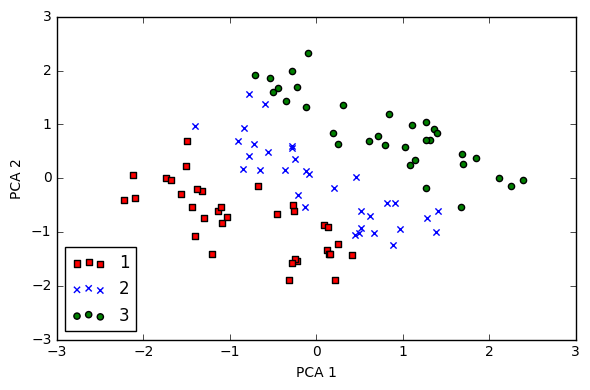

In [122]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

X_plot = X_pca

colors = ['r', 'b','g']
markers = ['s', 'x','o']

for l, c, m in zip(np.unique(y), colors, markers):
    plt.scatter(X_plot[y == l, 0], X_plot[y == l, 1], c=c, label=l, marker=m)
    
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

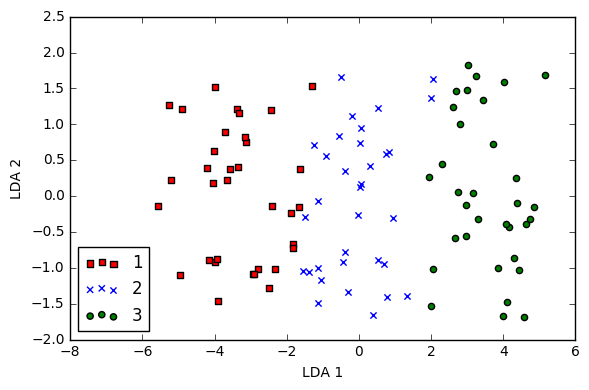

In [123]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_lda = lda.fit_transform(X_std, y)

X_plot = X_lda

colors = ['r', 'b','g']
markers = ['s', 'x','o']

for l, c, m in zip(np.unique(y), colors, markers):
    plt.scatter(X_plot[y == l, 0], X_plot[y == l, 1], c=c, label=l, marker=m)
    
plt.xlabel('LDA 1')
plt.ylabel('LDA 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

As shown, the data transformed by PCA and LDA varies a lot. If the data is projected to 1D, then PCA will have a much worse performance compared to LDA. 
My method to construct the dataset is to make the class category mainly dependent on just one variable.